# LOGISTIC REGRESSION & DECISION TREES FOR CREDIT RISK MODELLING

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toad
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from empiricaldist import Pmf
from empiricaldist import Cdf
from scipy.stats import shapiro, zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import scipy.stats


pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## HELPER FUNCTIONS

In [2]:
def is_column_numerical(df: pd.DataFrame, column_name: str) -> bool:
    """
    Checks if the specified column in the DataFrame is of a numerical datatype.

    Args:
        df (pd.DataFrame): The DataFrame containing the column.
        column_name (str): The name of the column to check.

    Returns:
        bool: True if the column is numerical, False otherwise.
    """
    return pd.api.types.is_numeric_dtype(df[column_name])

def credit_history_in_months(val: str) -> int:
    """
    Converts a credit history string in the format '<years> years <months> months' into total months.

    Args:
        val (str): The credit history string to convert.

    Returns:
        int: The total number of months, or None if the input is null.
    """
    if pd.notnull(val):
        years = int(val.split(' ')[0])
        month = int(val.split(' ')[3])
        return (years * 12) + month
    else:
        return val

def plot_histogram(data: np.ndarray, bins: int, title: str, xlabel: str = None, ylabel: str = None, color: str = "red") -> None:
    """
    Plots a histogram with percentage frequencies.

    Args:
        data (np.ndarray): The data to plot.
        bins (int): The number of bins for the histogram.
        title (str): The title of the histogram.
        xlabel (str, optional): The label for the x-axis. Defaults to None.
        ylabel (str, optional): The label for the y-axis. Defaults to None.
        color (str, optional): The color of the histogram bars. Defaults to "red".
    """
    counts, bin_edges, patches = plt.hist(data, bins=bins, color=color, weights=np.ones_like(data) / len(data) * 100)
    plt.title(title, fontsize=10, fontweight='bold')
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

def create_cdf_plot(figsize1: float, figsize2: float, col: pd.Series, threshold: float, title: str, xlabel: str) -> None:
    """
    Creates a Cumulative Distribution Function (CDF) plot for a given column, marking the 95th percentile.

    Args:
        figsize1 (float): The width of the figure.
        figsize2 (float): The height of the figure.
        col (pd.Series): The column of data to analyze.
        threshold (float): The maximum value to consider for the plot.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
    """
    plt.figure(figsize=(figsize1, figsize2))

    list_col = list(col.loc[col < threshold])

    sorted_col = np.sort(list_col)
    cdf_values = np.arange(1, len(sorted_col) + 1) / len(sorted_col)

    percentile_95 = np.percentile(sorted_col, 95)

    plt.plot(sorted_col, cdf_values, marker='.', linestyle='none', label="Cumulative Density")
    plt.axhline(0.95, color='red', linestyle='dotted', label="95% Threshold")
    plt.axvline(percentile_95, color='blue', linestyle='dotted', label=f"95% at {percentile_95:.2f}")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Cumulative Density")
    plt.grid(True, linestyle='dotted')
    plt.legend()
    plt.show()

    print(f"95th Percentile {percentile_95:.2f} of {xlabel}")

def remove_outliers_using_IQR(col: pd.Series, factor: float, name_col: str) -> pd.Series:
    """
    Identifies and returns outliers in a column using the Interquartile Range (IQR) method.

    Args:
        col (pd.Series): The column of data to analyze.
        factor (float): The multiplying factor for the IQR.
        name_col (str): The name of the column for display purposes.

    Returns:
        pd.Series: The outliers in the column.
    """
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    IQR = q3 - q1

    lower_limit = q1 - (IQR * factor)
    upper_limit = q3 + (IQR * factor)

    is_lower = col < lower_limit
    is_upper = col > upper_limit

    outliers = col[is_lower | is_upper]
    print(f"There were {len(outliers)} outliers in the {name_col} column.")

    return outliers

def outlier_removal_modelling(data: pd.DataFrame, colname: str, factor: float) -> pd.DataFrame:
    """
    Removes outliers from a DataFrame column using the Interquartile Range (IQR) method.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        colname (str): The name of the column to process.
        factor (float): The multiplying factor for the IQR.

    Returns:
        pd.DataFrame: The DataFrame with outliers removed.
    """
    q1 = data[colname].quantile(0.25)
    q3 = data[colname].quantile(0.75)
    IQR = q3 - q1

    lower_limit = q1 - (IQR * factor)
    upper_limit = q3 + (IQR * factor)

    print(f"There were {data.loc[(data[colname] < lower_limit) | (data[colname] > upper_limit)].shape[0]} outliers in the {colname} column.")

    data = data.loc[data[colname] >= lower_limit]
    data = data.loc[data[colname] <= upper_limit]

    return data


### Import Data & Initial Basic Checks

In [3]:
# Import core data - training data set with full history.
# Low memory to ensure no mixed data type inference.
train_data = pd.read_csv("train.csv", low_memory=False)

# Import test and validation datasets
test_data = pd.read_csv("test.csv", low_memory=False)
validation_data = pd.read_csv("validation.csv", low_memory=False)

In [4]:
# Make a copy so we can easily reset & for EDA.
df = train_data.copy()
df1 = test_data.copy()
df2 = validation_data.copy()

In [5]:
# See how many rows / cols we have in our datasets
print("There are {} rows and {} columns in the core TRAINING dataset".format(df.shape[0],df.shape[1]))
print("There are {} rows and {} columns in the TEST dataset".format(df1.shape[0],df1.shape[1]))
print("There are {} rows and {} columns in the VALIDATION dataset".format(df2.shape[0],df2.shape[1]))

There are 100000 rows and 30 columns in the core TRAINING dataset
There are 25000 rows and 30 columns in the TEST dataset
There are 25000 rows and 29 columns in the VALIDATION dataset


In [6]:
# Add dummy NULLS to taget column in validation data as we are going to concatenate.
df2["credit_score_target"]=None

# Create column in each which identifies the split when it comes to model building.
df["data_cat"]="train"
df1["data_cat"]="test"
df2["data_cat"]="validation"

In [7]:
# Concatenate train, test and validation. I only want to split data after preprocessing & treatment.
df3 = pd.concat([df, df1, df2])

# Check shape to ensure concat worked correctly
print(df3.shape)

(150000, 31)


In [8]:
# See what the unique identifier is and where duplication occurs.
df3["customer_id"].nunique()
dupes = df3[["customer_id", "data_cat", "month"]].loc[df3["customer_id"].duplicated()]
dupes["data_cat"].value_counts()

# Shape = 0 shows each row can be uniquely identified using a combinating of customer_id and month.
df3[df3.duplicated(subset=["customer_id","month"], keep=False)].shape[0]

0

In [9]:
# Validate customer_id represents 1 unique customer with NI number.
df3["customer_id"].nunique()==df3["national_insurance_number"].nunique()

# There seems to be some duplicates of name but that is possible - some people have the same names.
# So no cause for concern.
# df.loc[df["name"].duplicated()]

True

### SUMMARY:

- There are 100k rows in our training dataset and 100k unique customer IDs - this shows our datset is customer-level data. So each row represents 1 customer.

- The training dataset contains the entire population of customers. We have 100k unique customers.
- 25k of those (duplicated) put into a test dataset to see performance in Sept-Dec.
- 25k of those (duplicated) put into a validation dataset to see performance in Spet-Dec.

- The data shows 100k unique customers each month, for 8 months (Jan - Aug)


- Customer ID and National Insurance Numbers are analogous, so we can confirm that each row in the dataset represents 1 unique customer.

## Exploratory Data Analysis

##### What is each column in the dataset - type, distribution and relationshio to target variable?
For each feature:
- Check the datatype of the column and if that is inline with expectations. Is transformation/parsing required?
- Check NULL values / missing data. Treat missing data by imputing or dropping values, former preffered.
- Check presence of outliers and skewness of data.
- Check for abnormal or incorrect values and treat.

#### Annual Income

In [10]:
# Column is of Floating Point Number Data Type.
print("The Annual Income column is of %s datatype. " % (df3["annual_income"].dtype))

# No missing data in this field.
print("%d%% of the data is missing for this feature" % (round((df3.loc[df3["annual_income"].isnull()].shape[0]/100000)*100, 0)))

# Highest salary is £24,000,000 pa and lowest is ~£7000 pa. Avergae salary is £176k.
print(df3["annual_income"].describe())

The Annual Income column is of float64 datatype. 
0% of the data is missing for this feature
count    1.500000e+05
mean     1.730552e+05
std      1.404215e+06
min      7.005930e+03
25%      1.945549e+04
50%      3.757861e+04
75%      7.279690e+04
max      2.419806e+07
Name: annual_income, dtype: float64


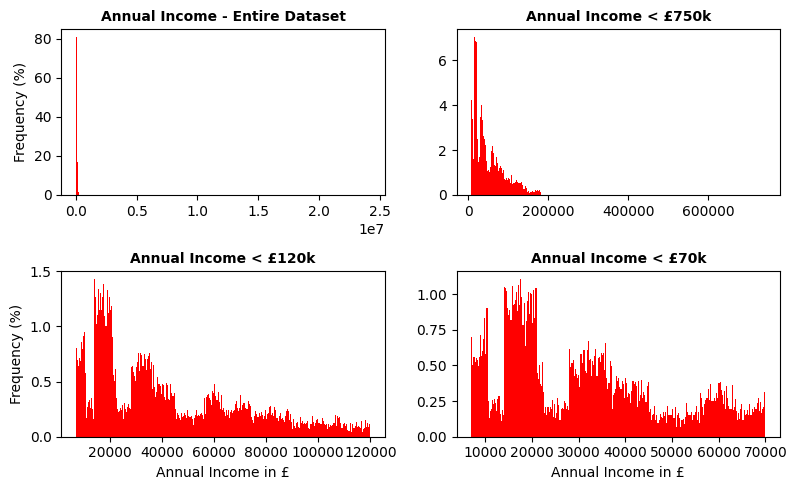

In [11]:
# The highest salary is almost 130 times biggest than the average salary.
# This would indicate data is highly skewed or presence of outliers.
# Generate some histograms using different thresholds to show this.

plt.figure(figsize=(8, 5))

# Histogram of entire dataset - ALL data
plt.subplot(2, 2, 1)
plot_histogram(df["annual_income"],
               bins=int(np.sqrt(len(df))),
               title="Annual Income - Entire Dataset",
               ylabel="Frequency (%)")

# Histogram of Annual Income < 750k
plt.subplot(2, 2, 2)
under_750k = df.loc[df["annual_income"] <= 750_000.0]
plot_histogram(under_750k["annual_income"],
               bins=int(np.sqrt(len(under_750k))),
               title="Annual Income < £750k")

# Histogram of Annual Income < 120k
plt.subplot(2, 2, 3)
under_120k = df.loc[df["annual_income"] <= 120_000.0]
plot_histogram(under_120k["annual_income"],
               bins=int(np.sqrt(len(under_120k))),
               title="Annual Income < £120k",
               xlabel="Annual Income in £",
               ylabel="Frequency (%)")

# Histogram of Annual Income < 70k
plt.subplot(2, 2, 4)
under_70k = df.loc[df["annual_income"] <= 70_000.0]
plot_histogram(under_70k["annual_income"],
               bins=int(np.sqrt(len(under_70k))),
               title="Annual Income < £70k",
               xlabel="Annual Income in £")

plt.tight_layout()
plt.show()

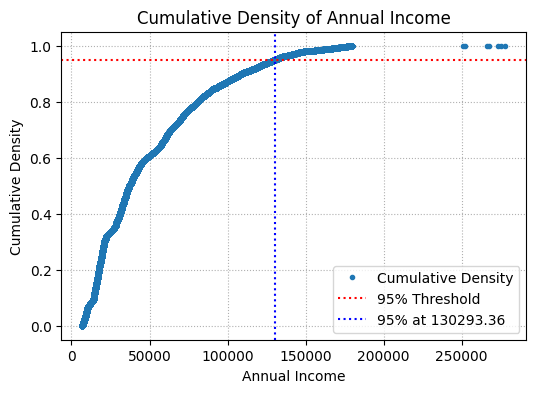

95th Percentile 130293.36 of Annual Income


In [12]:
# Want to determine what the ideal cutoff is for outliers. CDF can give more specific information.
# Create a CDF of Annual Income - CDF: probability you get a value <= x for any given value of x.
create_cdf_plot(figsize1=6,
                figsize2=4,
                col=df3["annual_income"],
                threshold=300_000.0,
                title="Cumulative Density of Annual Income",
                xlabel="Annual Income")

##### SUMMARY ###

- No missing data in this feature.
- The datatype is float so we can assume no unwanted characters or syntax errors.

- I suspect outliers. Let's plot some histograms with different cut-offs for the highest salary and see at what value we can get the data to form somewhat of a normal distribution. Outliers in data disproportionately affect the calculation of regression coefficients resulting in a worse fit and poor predictive performance.

- Using describe() for summary statistics we can see that the maximum value for annual income is x137 larger than the average. This is very suspicious and leads me to believe there are possible outliers in the dataset or the data is heavily skewed.

- Say something abot outliers - data was treated for outliers
- Positive correlation between annual income and credit score - this is a useful feature to have in our model and so we will use it.

- I have chosen NOT to remove outliers because at this point I don't want to DROP any data.
- When we perform Binning it will neutralize the effects of outliers as outliers are binned with the nearest group.

### Age

In [13]:
# Column is string (object) data type.
print("The Age column is %s datatype. " % (df3["age"].dtype))

# Age is a numerical value - so understand why datatype was parsed to string?
list(df3["age"].unique())

# We see some trailing '_' underscore characters.
# Strip the unwanted underscore chars at beginning or end.
df3["age"] = df3["age"].str.strip("_")

# Convert to integer datatype
df3["age"] = df3["age"].astype(int)

# No missing data in this field.
print("%d%% of the data is missing for this feature" % (round((df3.loc[df3["age"].isnull()].shape[0]/100000)*100, 0)))

# describe() summary stats show we have an erroneous value of -500 & also outlier/incorrect values >100
print(df3["age"].describe())

# 886 records have age = -500. Assume incorrect/data missing.
df3.loc[df3["age"]==-500].shape[0]
print("{} %% of the AGE values are '-500' (missing/unknown)".format(
    round((886/df3.shape[0])*100, 2)
))

The Age column is object datatype. 
0% of the data is missing for this feature
count    150000.000000
mean        110.337940
std         684.066779
min        -500.000000
25%          25.000000
50%          33.000000
75%          42.000000
max        8698.000000
Name: age, dtype: float64
0.59 %% of the AGE values are '-500' (missing/unknown)


In [14]:
# Boxplot looks totally unbalanced, so let's use IQR to identifiy outliers.
# Let's drop the values of -500 for now as they will skew the metrics.
age_data = df3.loc[df3["age"]!=-500]

In [15]:
# Identify outliers using helper function which uses IQR method.
outliers = remove_outliers_using_IQR(col = age_data["age"], factor=1.5, name_col="Age")

# Remove outliers from AGE feature.
age_data = age_data.loc[~(age_data["age"].isin(list(outliers)))]

# Calculate a median value, now we have a more balanced dataset.
median_age = age_data["age"].median()

# Impute -500 with median value.
df3["age"] = np.where(df3["age"] == -500, median_age, df3["age"])

# Make a copy before I remove outliers - as I am not sure I want to drop data yet.
df4 = df3.copy()

# Remove outliers and store in new dataframe.
df4 = df4.loc[~(df4["age"].isin(list(outliers)))]

There were 2834 outliers in the Age column.


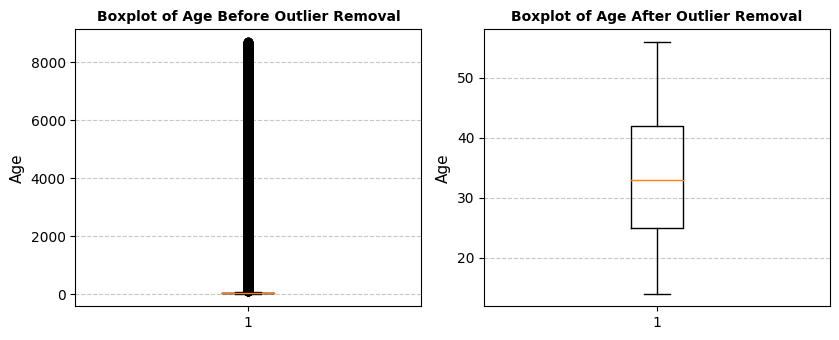

In [16]:
# Set up a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.5), sharey=False)

# Boxplot for the 'age' column before outlier removal
axes[0].boxplot(df3["age"])
axes[0].set_title("Boxplot of Age Before Outlier Removal", fontsize=10, fontweight='bold')
axes[0].set_ylabel("Age", fontsize=11)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot for the 'age' column after outlier removal
axes[1].boxplot(df4["age"])
axes[1].set_title("Boxplot of Age After Outlier Removal", fontsize=10, fontweight='bold')
axes[1].set_ylabel("Age", fontsize=11)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better display
plt.tight_layout()
plt.show()

##### SUMMARY ###

- Outlier detection and removal - with AGE we do want to remove them becuase it's legit impossible to have 200 years old.
- No missing data in this feature.
- df3 is still the whole dataset, df4 is ater outlier removal (2834 rows dropped, 1.9% of total data)

#### Number of Bank Accounts & Number of Credit Cards

In [17]:
# Columns are of Integer Data Type and have no missing values.
df3[["num_bank_accounts", "num_credit_card"]].info()

# We see high variance and max values are big deviation from the mean, indicating outliers.
df3[["num_bank_accounts", "num_credit_card"]].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   num_bank_accounts  150000 non-null  int64
 1   num_credit_card    150000 non-null  int64
dtypes: int64(2)
memory usage: 3.4 MB


,num_bank_accounts,num_credit_card
count,150000.000000,150000.000000
mean,17.006940,22.623447
std,117.069476,129.143006
min,-1.000000,0.000000
25%,3.000000,4.000000
50%,6.000000,5.000000
75%,7.000000,7.000000
max,1798.000000,1499.000000


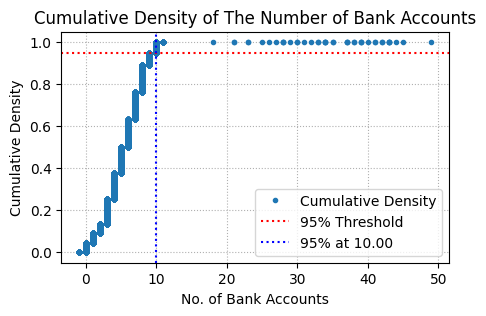

95th Percentile 10.00 of No. of Bank Accounts


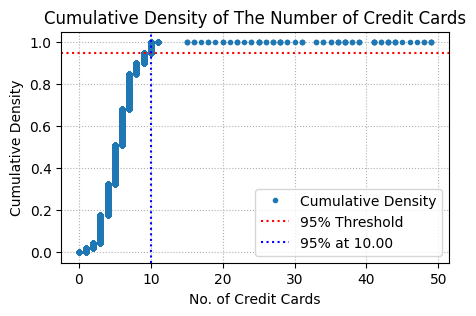

95th Percentile 10.00 of No. of Credit Cards


In [18]:
# CDF plot to see cut-off point at which most of the data is accounter for.
# After this we can consider data points to be outliers or extreme values.
create_cdf_plot(figsize1=5,
                figsize2=3,
                col=df3["num_bank_accounts"],
                threshold=50,
                title="Cumulative Density of The Number of Bank Accounts", xlabel="No. of Bank Accounts")

# CDF of Credit Card volume shows similar spread of data with outliers after n=10.
create_cdf_plot(figsize1=5,
                figsize2=3,
                col=df3["num_credit_card"],
                threshold=50,
                title="Cumulative Density of The Number of Credit Cards", xlabel="No. of Credit Cards")

In [19]:
# Get rid of all values of bank accounts/credit cards greater than 10.0. For data vis purpose only.
df_num_banks_cards = df3.loc[(df3["num_bank_accounts"]<=10)]
df_num_banks_cards = df_num_banks_cards.loc[(df_num_banks_cards["num_credit_card"]<=10)]

Text(0.5, 1.02, 'Number of Bank Accounts vs. Credit Cards')

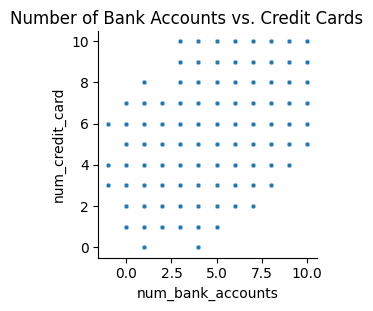

In [20]:
# Scatter plot to see if there's any correlation between variables.
plot = sns.relplot(data=df_num_banks_cards,
                   x="num_bank_accounts",
                   y="num_credit_card",
                   height=3,
                   aspect=1,
                   kind='scatter',
                   s=10)

plot.fig.suptitle("Number of Bank Accounts vs. Credit Cards", y=1.02)

#### SUMMARY
 
 
- Columns are of Integer Data Type, so can assume no syntax errors or weird characters.
- There are 0 rows with missing data as shown by the 'Non-Null Count' header below
- Plotting a histogram with ALL the data showed that most of it seemed to be within 15 bank accounts - EXPAND.
- I just did trial and error until I got something which resembled a normal distribution. THEN test for normality.
- I am going to leave the outliers in here for now as this will be treated with BINNING and I don't want to lose any more data.
- There seems to be a weak positive correlation between the number of bank accounts and number of credit cards.


#### Occupation

In [21]:
# Column is of Integer Data Type.
print("The Occupation column is of %s datatype. " % (df3["occupation"].dtype))

# No missing data in this field.
print("%d%% of the data is missing for this feature" % (round((df3.loc[df3["occupation"]
                                                                       .isnull()].shape[0]/100000)*100, 0)))

# Identify distinct occupations represented in this dataset.
df3["occupation"].unique()

# Can identify one erroneous category with '_______' as the value.
# Assume here the occupation is unknown and replace.
df3["occupation"] = df3["occupation"].replace("_______", "Unknown")

The Occupation column is of object datatype. 
0% of the data is missing for this feature


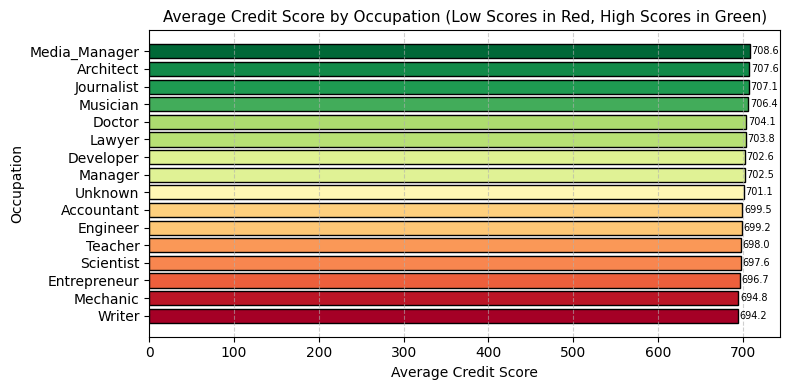

In [22]:
# Calculate the average credit score by occupation
avg_credit_score = df3.groupby('occupation')['credit_score_target'].mean().sort_values()

# Normalize the credit scores for color mapping
normalized_scores = (avg_credit_score - avg_credit_score.min()) / (avg_credit_score.max() - avg_credit_score.min())
colors = plt.cm.RdYlGn(normalized_scores)  # Use the RdYlGn colormap

# Plot with normalized colors
plt.figure(figsize=(8, 4))
bars = plt.barh(avg_credit_score.index, avg_credit_score, color=colors, edgecolor='black')
plt.xlabel('Average Credit Score', fontsize=10)
plt.ylabel('Occupation', fontsize=10)
plt.title('Average Credit Score by Occupation (Low Scores in Red, High Scores in Green)', fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add data labels
for bar in bars:
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.1f}', va='center', fontsize=7)

plt.tight_layout()
plt.show()

### SUMMARY

- Here's a horizontal bar chart illustrating the average credit score for each occupation. The colors reflect the values, creating a visually engaging and informative representation.
- Here’s how to explicitly normalize the data and apply the gradient:
- This approach explicitly normalizes the data and applies the gradient correctly. Let me know if you need further clarification!


#### Days Late & Number of Missed Payments

In [23]:
# Column is of Integer Data Type.
print("The Days Late column is of %s datatype. " % (df3["delay_from_due_date"].dtype))

# No missing data in this field.
print("%d%% of the data is missing for this feature"%(round((df3.loc[df3["delay_from_due_date"].isnull()].shape[0]/100000)*100, 0)))
print(" ")

# Column is of Float Data Type.
print("The Missing Payments column is of %s datatype. "%(df3["num_of_delayed_payment"].dtype))

# 10% NULL values / missing data in this field.
print("%d%% of the data is missing for this feature"%(round((df3.loc[df3["num_of_delayed_payment"].isnull()].shape[0]/100000)*100, 0)))

The Days Late column is of int64 datatype. 
0% of the data is missing for this feature
 
The Missing Payments column is of float64 datatype. 
10% of the data is missing for this feature


In [24]:
# No. of delayed payments has outliers/extreme values. Also negative values make no sense.
df3[["delay_from_due_date", "num_of_delayed_payment"]].describe()

,delay_from_due_date,num_of_delayed_payment
count,150000.000000,139500.000000
mean,21.063400,30.911878
std,14.860154,224.534007
min,-5.000000,-3.000000
25%,10.000000,9.000000
50%,18.000000,14.000000
75%,28.000000,18.000000
max,67.000000,4399.000000


In [25]:
# Going to assume negatives are just 'current' customers - they are not late on any payments.
# Keeping negatives might imply that you are a better customer the more negative you are.
df3["delay_from_due_date"] = np.where(df3["delay_from_due_date"]<0, 0, df3["delay_from_due_date"])

# Check to make sure replacing negatives worked. Should be empty array.
df3["delay_from_due_date"].loc[df3["delay_from_due_date"]<0].unique()

array([], dtype=int64)

In [26]:
# Delayed payments has NaN so we impute them with the median following outlier treatment.
outliers_delayed_payments = remove_outliers_using_IQR(col=df3["num_of_delayed_payment"],
                                                      factor=1.5,
                                                      name_col="Delayed Payments")

# Remove outliers just so we can calculate a more accurate median value.
df_treated_delayed_payments = df3.loc[~(df3["num_of_delayed_payment"].isin(list(outliers_delayed_payments)))]

# Calculate a median value, now we have a more balanced dataset.
median_delayed_payments = df_treated_delayed_payments["num_of_delayed_payment"].median()

# Original dataset.
df3["num_of_delayed_payment"] = np.where(df3["num_of_delayed_payment"].isnull(),
                                        median_delayed_payments,
                                        df3["num_of_delayed_payment"])

There were 1131 outliers in the Delayed Payments column.


In [27]:
# I want to investigate the correlation between these variables
df1_treated_delayed_payments = df_treated_delayed_payments.loc[df_treated_delayed_payments["num_of_delayed_payment"].notnull()]

# R correlation coefficient shows moderate positive linear relationship.
scipy.stats.pearsonr(df1_treated_delayed_payments["delay_from_due_date"],
                     df1_treated_delayed_payments["num_of_delayed_payment"])    # Pearson's r

PearsonRResult(statistic=0.5403906233869158, pvalue=0.0)

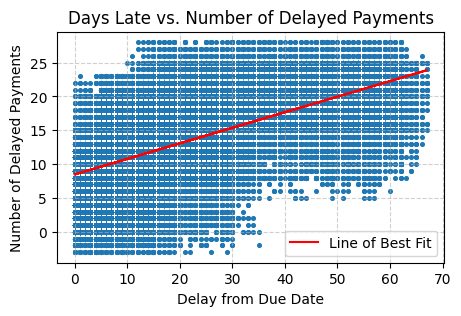

In [28]:
# Plot the actual data points
plt.figure(figsize=(5, 3))

plt.scatter(df1_treated_delayed_payments["delay_from_due_date"],
            df1_treated_delayed_payments["num_of_delayed_payment"],
            s=7)

# Calculate the line of best fit
x = df1_treated_delayed_payments["delay_from_due_date"]
y = df1_treated_delayed_payments["num_of_delayed_payment"]
m, b = np.polyfit(x, y, 1)  # Linear regression (slope and intercept)

# Plot the line of best fit
plt.plot(x, m*x + b, color="red", label="Line of Best Fit")

plt.title("Days Late vs. Number of Delayed Payments")
plt.xlabel("Delay from Due Date")
plt.ylabel("Number of Delayed Payments")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

#### SUMMARY:

- I would have liked to use a simple regression value to fill in the missing data here in delayed payments column.
- This column would be useful but there is a bunch of missing data - can we impute from delay from due date??

There is a moderate positive linear relationship between delay_from_due_date and num_of_delayed_payment. As one increases, the other tends to increase as well.
Statistical Significance: The 
𝑝
p-value confirms that this relationship is statistically significant and not likely due to random variation in your data.

#### Payment Behaviour

In [29]:
# Column is of Object Data Type.
print("The Payment column is of %s datatype. " % (df3["payment_behaviour"].dtype))

# No missing data in this field.
print("%d%% of the data is missing for this feature"%(round((df3.loc[df3["payment_behaviour"]
                                                                     .isnull()].shape[0]/100000)*100, 0)))

# An erroneous value of '!@9#%8' appears. Assume payment behaviour in this case is unknown.
df3["payment_behaviour"].unique()

# Assume payment behaviour in this case is unknown.
df3["payment_behaviour"] = np.where(df3["payment_behaviour"]=="!@9#%8", "Unknown", df3["payment_behaviour"])

The Payment column is of object datatype. 
0% of the data is missing for this feature


#### Outstanding Debt

In [30]:
# Column is of Float Data Type.
print("The Outstanding Debt column is of %s datatype. " % (df3["outstanding_debt"].dtype))

# No missing data in this field.
print("%d%% of the data is missing for this feature"%(round((df3.loc[df3["outstanding_debt"]
                                                                     .isnull()].shape[0]/100000)*100, 0)))

The Outstanding Debt column is of float64 datatype. 
0% of the data is missing for this feature


In [31]:
df3["outstanding_debt"].describe()
print("{} records which show a negative value.".format(df3.loc[df3["outstanding_debt"]<0].shape[0]))

50000 records which show a negative value.


In [32]:
# Identify outliers using helper function which uses IQR method.
outliers_debt = remove_outliers_using_IQR(col = df3["outstanding_debt"], factor=1.5, name_col="Outstanding Debt")

# Remove outliers and store in new dataframe.
outstanding_debt = df3.loc[~(df3["outstanding_debt"].isin(list(outliers_debt)))]
outstanding_debt = outstanding_debt[["customer_id", "month","outstanding_debt", "credit_score_target"]]

There were 7732 outliers in the Outstanding Debt column.


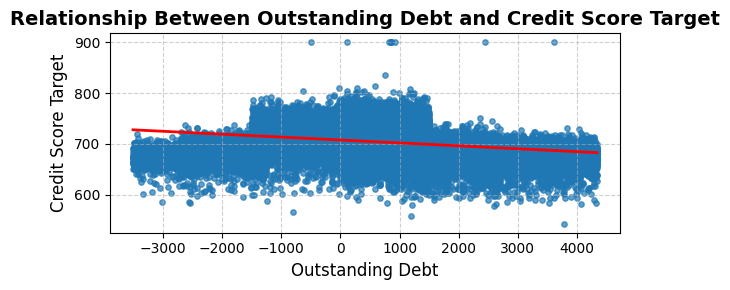

In [33]:
# Create a scatter plot with a regression line to visualize the relationship
plt.figure(figsize=(6, 3))
sns.regplot(
    x="outstanding_debt",
    y="credit_score_target",
    data=outstanding_debt,
    scatter_kws={"s": 15, "alpha": 0.7},
    line_kws={"color": "red", "linewidth": 2},  # Customize regression line
)

# Add titles and labels for better readability
plt.title("Relationship Between Outstanding Debt and Credit Score Target", fontsize=14, fontweight="bold")
plt.xlabel("Outstanding Debt", fontsize=12)
plt.ylabel("Credit Score Target", fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

#### Credit History Age

In [34]:
# Column is of Float Data Type.
print("The Credit History Age is of %s datatype. " % (df3["credit_history_age"].dtype))

# 14% data missing data in this field.
print("%d%% of the data is missing for this feature"%(round((df3.loc[df3["credit_history_age"].isnull()].shape[0]/100000)*100, 0)))

# Immediately notice credit_history_age is a string which we will need to convert to numerical value.
df3["credit_history_age"].unique()

# Applying the function to the column
df3["credit_history_age"] = df3["credit_history_age"].apply(lambda x: credit_history_in_months(x)).astype(float)

The Credit History Age is of object datatype. 
14% of the data is missing for this feature


In [35]:
# CHECK now to make sure column is converted to numeric datatype. 
print("The Credit History Age is of %s datatype. " % (df3["credit_history_age"].dtype))

The Credit History Age is of float64 datatype. 


In [36]:
# Let's fill in missing data with an average value.
outliers_credit_age = remove_outliers_using_IQR(col = df3["credit_history_age"], factor=1.5, name_col="Credit History Age")

# Remove outliers from feature.
credit_age_data = df3.loc[~(df3["credit_history_age"].isin(list(outliers_credit_age)))]

# Calculate a median value, now we have a more balanced dataset.
median_credit_age = credit_age_data["credit_history_age"].median()

# Impute NULL with median value.
df3["credit_history_age"] = np.where(df3["credit_history_age"].isnull(), median_credit_age, df3["credit_history_age"])

There were 0 outliers in the Credit History Age column.


#### Number of Loans

In [37]:
# Column is of Float Data Type.
print("The Number of Loans is of %s datatype. " % (df3["num_of_loan"].dtype))

# No data missing data in this field.
print("%d%% of the data is missing for this feature"%(round((df3.loc[df3["num_of_loan"].isnull()].shape[0]/100000)*100, 0)))

# 3713 which are below 0 (doesn't really make sense to have a negative number of loans).
tt1 = df3[["customer_id", "num_of_loan"]].loc[df3["num_of_loan"]<0]

# There are ALL -100, so we can assume that '-100' here means unknown/we don't know the number of loans.
# tt1["num_of_loan"].unique()

The Number of Loans is of float64 datatype. 
0% of the data is missing for this feature


#### Type of Loan

In [38]:
# Column is of Object Type.
print("The Type of Loan is of %s datatype. " % (df3["type_of_loan"].dtype))

# 11% missing data in this field.
print("%d%% of the data is missing for this feature"%(round((df3.loc[df3["type_of_loan"].isnull()].shape[0]/100000)*100, 0)))

The Type of Loan is of object datatype. 
17% of the data is missing for this feature


In [39]:
# Fill NULL values with 'not specified' which is also the mode value
df3["type_of_loan"] = df3["type_of_loan"].fillna("Not Specified")

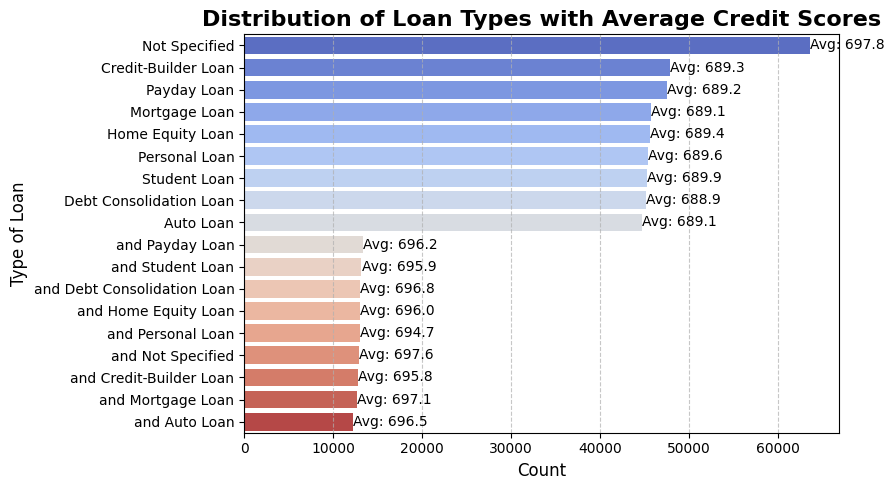

In [40]:
# Split the `type_of_loan` column into individual loan types
df_tt2_expanded = df3[["customer_id", "type_of_loan", "credit_score_target"]]
df_tt2_expanded = df_tt2_expanded.assign(type_of_loan=df_tt2_expanded["type_of_loan"].str.split(", "))

# Explode the DataFrame to have one loan type per row
df_tt2_expanded = df_tt2_expanded.explode("type_of_loan")

# Calculate the average credit score for each loan type
average_credit_scores = (df_tt2_expanded.groupby("type_of_loan")["credit_score_target"]
                         .mean()
                         .reindex(df_tt2_expanded["type_of_loan"].value_counts().index))

# Create the plot with the average credit score as labels
plt.figure(figsize=(9, 5))
sns.countplot(data=df_tt2_expanded,
              y="type_of_loan",
              order=df_tt2_expanded["type_of_loan"].value_counts().index,
              palette="coolwarm")

# Add average credit score labels to the bars
for index, value in enumerate(df_tt2_expanded["type_of_loan"].value_counts()):
    avg_score = average_credit_scores.iloc[index]
    plt.text(
        value + 1,  # Position to the right of the bar
        index,  # Bar position
        f"Avg: {avg_score:.1f}",  # Format average credit score
        va="center",
        fontsize=10,
        color="black"
    )

# Add titles and labels
plt.title("Distribution of Loan Types with Average Credit Scores", fontsize=16, fontweight="bold")
plt.xlabel("Count", fontsize=12)
plt.ylabel("Type of Loan", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

#### Payment of Min Amount

In [41]:
# Column is of Object Data Type - but Data Dictionary says this column should be boolean.
print("The Payment of Min Amount column is of %s datatype. " % (df3["payment_of_min_amount"].dtype))

# No NULL values in this field.
print("%d%% of the data is a NULL value for this feature"%(round((df3.loc[df3["payment_of_min_amount"].isnull()].shape[0]/100000)*100, 0)))

# There is a value 'NM' which I assume means unknown as Data Dictionary indicates col boolean.
print(df3["payment_of_min_amount"].unique())

# 12% of the data is Unknown or Missing.
print("{}% of the data has an incorrect value of NM.".format(round((df3.loc[df3["payment_of_min_amount"]=="NM"].shape[0]/df3.shape[0])*100),2))

# Impute 'NM' values with mode / most frequently occuring value.
mode = df3["payment_of_min_amount"].mode()
df3["payment_of_min_amount"] = np.where(df3["payment_of_min_amount"] == "NM", mode, df3["payment_of_min_amount"])
df3["payment_of_min_amount"].value_counts()

The Payment of Min Amount column is of object datatype. 
0% of the data is a NULL value for this feature
['No' 'NM' 'Yes']
12% of the data has an incorrect value of NM.


Yes    96484
No     53516
Name: payment_of_min_amount, dtype: int64

#### Amount Invested Monthly

In [42]:
# Column is of Object Data Type - but Data Dictionary says this column should be boolean.
print("Amount Invested Monthly column is of %s datatype. " % (df3["amount_invested_monthly"].dtype))

# 7% of Data is NULL for this feature.
print("%d%% of the data is a NULL value for this feature"%(
    round((df3.loc[df3["amount_invested_monthly"].isnull()].shape[0]/100000)*100, 0)))

# We do have ~150 values which = 0.0, but it's a very small proportion and this is entirely possible.
print("{} values are 0.0 but no cause for concernt as this is possible."
      .format(df3[["customer_id", "amount_invested_monthly"]].loc[df3["amount_invested_monthly"]==0.0].shape[0]))

Amount Invested Monthly column is of float64 datatype. 
7% of the data is a NULL value for this feature
275 values are 0.0 but no cause for concernt as this is possible.


In [43]:
# Let's impute missing values with an average.
# Data looks skewed so perform outlier removal to calculate mean.
outliers_amnt_inv = remove_outliers_using_IQR(col=df3["amount_invested_monthly"],
                                              factor=1.5, name_col="amount_invested_monthly")

# Remove outliers from feature.
amnt_inv_treated = df3.loc[~(df3["amount_invested_monthly"].isin(list(outliers_amnt_inv)))]

# Calculate a median value, now we have a more balanced dataset.
mean_amnt_inv = amnt_inv_treated["amount_invested_monthly"].mean()

# Impute missing data with mean value.
df3["amount_invested_monthly"] = np.where(df3["amount_invested_monthly"].isnull(), mean_amnt_inv, df3["amount_invested_monthly"])

There were 15127 outliers in the amount_invested_monthly column.


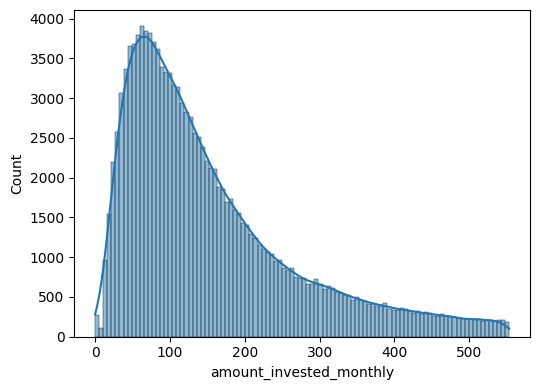

In [44]:
# Seaborn histogram shows Right-Skewed (Positively Skewed) distribution
vis = amnt_inv_treated.loc[amnt_inv_treated["amount_invested_monthly"].notnull()]

# Visualise.
plt.figure(figsize=(5.5, 4))
sns.histplot(data=vis, x="amount_invested_monthly", kde=True)
plt.tight_layout()  # Ensure everything fits well
plt.show()

#### Changed Credit Limit

In [45]:
# Column is of STRING datatype - incorrect. (should be numeric).
print("The Changed Credit Limit column is of %s datatype. " % (df3["changed_credit_limit"].dtype))

# 2% values in this field are NULL
print("%d%% of the data is a NULL value for this feature"%(round((df3.loc[df3["changed_credit_limit"].isnull()].shape[0]/100000)*100, 0)))

# 4 records have a changed credit limit = 0.0, which is possible.
df3.loc[df3["changed_credit_limit"]==0.0].shape[0]

The Changed Credit Limit column is of object datatype. 
2% of the data is a NULL value for this feature


4

In [46]:
# Field contains special characters that prevent it from being interpreted as numeric.
df3[["customer_id", "changed_credit_limit"]].loc[df3["changed_credit_limit"].str.contains(r'[_\s]', na=False)][:5]

# Clean the column and convert to numeric
df3["changed_credit_limit"] = pd.to_numeric(df3["changed_credit_limit"], errors='coerce')

# Quite a few cases where 'changed_credit_limit' has negative values - doesn't make sense to me.
# We will leave them for now as it's only 1% with negative values
print("{}% of the data has a negative value which seems unnatural."
      .format(round((df3[["customer_id", "changed_credit_limit"]].loc[df3["changed_credit_limit"]<0].shape[0]/df3.shape[0])*100, 2)))

1.61% of the data has a negative value which seems unnatural.


In [47]:
# Some more NULL data now this conversion has been done. Let's replace NULL with an average value.
outliers = remove_outliers_using_IQR(col = df3["changed_credit_limit"], factor=1.5, name_col="Changed Credit Limit")

# Remove outliers from Changed Credit Limit feature.
changed_credit_limit = df3.loc[~(df3["changed_credit_limit"].isin(list(outliers)))]

# Calculate a average, now we have a more balanced dataset.
average_credit_limit_changed = changed_credit_limit["changed_credit_limit"].mean()

# Now go back to original data and impute NULL data with this average amount.
df3["changed_credit_limit"] = np.where(df3["changed_credit_limit"].isnull(),
                                      average_credit_limit_changed,
                                      df3["changed_credit_limit"])

There were 1052 outliers in the Changed Credit Limit column.


In [48]:
### CHECKS ###
# Check the shape of the data is the SAME - we didn't want to drop any rows
print(df3["changed_credit_limit"].shape[0])

# Check that impute NULL values with average worked - should be no NULLs.
print(df3.loc[df3["changed_credit_limit"].isnull()].shape[0])

150000
0


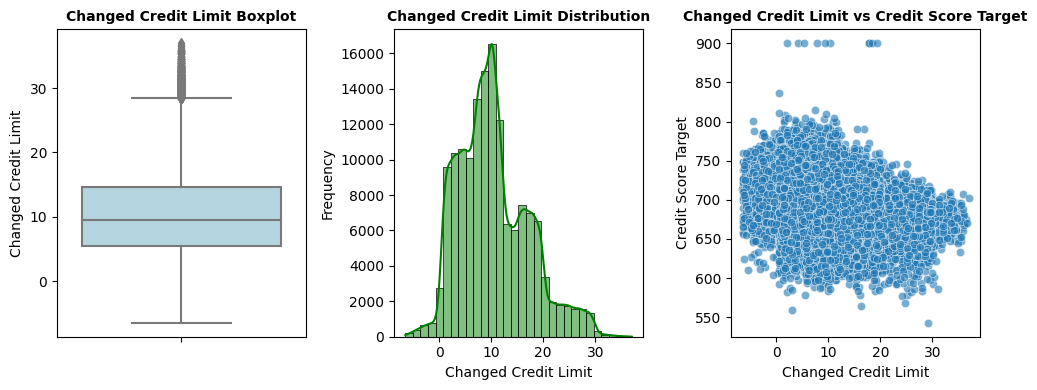

In [49]:
# Creating some basic visualizations to see distribution and relationship to credit score.
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Boxplot for changed_credit_limit
sns.boxplot(ax=axes[0], y=df3["changed_credit_limit"], color="lightblue")
axes[0].set_title('Changed Credit Limit Boxplot', fontsize=10, fontweight='bold')
axes[0].set_ylabel("Changed Credit Limit")
axes[0].set_xlabel('')

# Histogram for changed_credit_limit
sns.histplot(ax=axes[1], x=df3['changed_credit_limit'], bins=30, kde=True, color="green")
axes[1].set_title('Changed Credit Limit Distribution', fontsize=10, fontweight='bold')
axes[1].set_xlabel("Changed Credit Limit")
axes[1].set_ylabel("Frequency")

# Quick plot to see if there's a relationship between with credit_score_target.
sns.scatterplot(ax=axes[2], x=df3['changed_credit_limit'], y=df3["credit_score_target"], alpha=0.6)
axes[2].set_title("Changed Credit Limit vs Credit Score Target", fontsize=10, fontweight='bold')
axes[2].set_xlabel("Changed Credit Limit")
axes[2].set_ylabel("Credit Score Target")

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

#### SUMMARY:

- The changed_credit_limit variable was correctly parsed as a float in the training data, however in the test and validation datasets values were missing (represented as NaN), had spaces, or contained special characters. Thus prevented it from being interpreted as numeric.
- So the entire column when concatenating was coerced to a String/Object datatype. When there are inconsistencies in the column, pandas defaults to treating it as a string.
- There were ~1k rows which could not be converted missing data / NULL values. After coersion we have 3% missing data. I do not want to drop data, so we used an average value to fill in NULLs.

Boxplot of Changed Credit Limit: Shows the distribution of changed_credit_limit with potential outliers.
Histogram of Changed Credit Limit: Displays the frequency distribution with a kernel density estimate (KDE) overlay.
Scatter Plot (Changed Credit Limit vs Credit Score Target): Illustrates the relationship between changed_credit_limit and credit_score_target.

Reasons for Choosing 30 Bins:
- Many data visualization tools (like Matplotlib) use 30 bins as a default because it works well for a variety of datasets.
- Too few bins might oversimplify the data distribution, while too many bins could make the histogram cluttered and harder to interpret.
- Your dataset is large enough (~150,000 rows) to justify dividing it into more bins without making the histogram too sparse.
- A moderate bin size allows stakeholders to understand key patterns, such as the central tendency and spread, without being overwhelmed by excessive granularity.

#### Interest Rate

In [50]:
# Column is of integer datat-type.
print("The Interest Rate column is of %s datatype. " % (df3["interest_rate"].dtype))

# No missind data or null values in this field.
print("%d%% of the data is a NULL value for this feature"%(round((df3.loc[df3["interest_rate"].isnull()].shape[0]/100000)*100, 0)))

# No one has a 0% interest rate.
df3.loc[df3["interest_rate"]==0].shape[0]

The Interest Rate column is of int64 datatype. 
0% of the data is a NULL value for this feature


0

#### Number of Credit Inquiries

In [51]:
# Column is of Object Data Type - but Data Dictionary says this column should be boolean.
print("Number of Credit Inquiries column is of %s datatype. " % (df3["num_credit_inquiries"].dtype))

# No NULL values in this field.
print("%d%% of the data is a NULL value for this feature"%(
    round((df3.loc[df3["num_credit_inquiries"].isnull()].shape[0]/100000)*100, 0)))

Number of Credit Inquiries column is of float64 datatype. 
3% of the data is a NULL value for this feature


In [52]:
# Identify outliers using helper function which uses IQR method.
outliers_cred_inq = remove_outliers_using_IQR(col=df3["num_credit_inquiries"],
                                              factor=1.5,
                                              name_col="Number of CrediT Inquiries")

# Remove outliers from AGE feature.
cred_inq_treated = df3.loc[~(df3["num_credit_inquiries"].isin(list(outliers_cred_inq)))]

# Calculate a median value, now we have a more balanced dataset.
median_cred_inq = cred_inq_treated["num_credit_inquiries"].median()
mean_cred_inq = cred_inq_treated["num_credit_inquiries"].mean()

# Now go back to out ORIGINAL data - impute NULL with median value.
df3["num_credit_inquiries"] = np.where(df3["num_credit_inquiries"].isnull(),
                                       median_cred_inq,
                                       df3["num_credit_inquiries"])

# Also fill NULLS in the treated df for visualisation.
cred_inq_treated["num_credit_inquiries"] = np.where(cred_inq_treated["num_credit_inquiries"].isnull(),
                                                    median_cred_inq,
                                                    cred_inq_treated["num_credit_inquiries"])

There were 3989 outliers in the Number of CrediT Inquiries column.


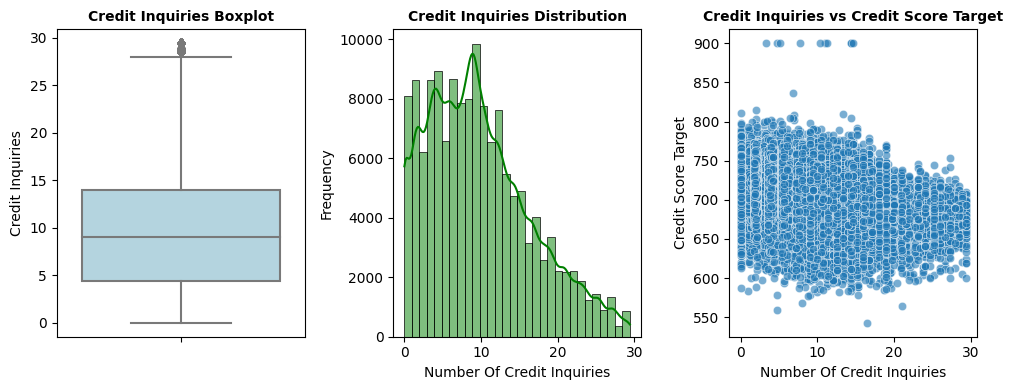

In [53]:
# Creating some basic visualizations to see distribution and relationship to credit score.
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Boxplot
sns.boxplot(ax=axes[0], y=cred_inq_treated["num_credit_inquiries"], color="lightblue")
axes[0].set_title('Credit Inquiries Boxplot', fontsize=10, fontweight="bold")
axes[0].set_ylabel("Credit Inquiries")
axes[0].set_xlabel('')

# Histogram
sns.histplot(ax=axes[1], x=cred_inq_treated['num_credit_inquiries'], bins=30, kde=True, color="green")
axes[1].set_title('Credit Inquiries Distribution', fontsize=10, fontweight="bold")
axes[1].set_xlabel("Number Of Credit Inquiries")
axes[1].set_ylabel("Frequency")

# Quick plot to see if there's a relationship between with credit_score_target.
sns.scatterplot(ax=axes[2], x=cred_inq_treated['num_credit_inquiries'], y=cred_inq_treated["credit_score_target"], alpha=0.6)
axes[2].set_title("Credit Inquiries vs Credit Score Target", fontsize=10, fontweight='bold')
axes[2].set_xlabel("Number Of Credit Inquiries")
axes[2].set_ylabel("Credit Score Target")

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

#### Monthly Balance

In [54]:
# Column is of float datatype.
print("The Monthly Balance column is of %s datatype. " % (df3["monthly_balance"].dtype))

# 1% values in this field are NULL
print("%d%% of the data is a NULL value for this feature"%(round((df3.loc[df3["monthly_balance"].isnull()].shape[0]/100000)*100, 0)))

# No one seems to have a monthly balance of £0
print("{} rows where the monthly balance is = 0.0".format(df3.loc[df3["monthly_balance"]==0.0].shape[0]))

The Monthly Balance column is of float64 datatype. 
2% of the data is a NULL value for this feature
0 rows where the monthly balance is = 0.0


In [55]:
# Having NULLs won't work for modelling so we impute them with average value following outlier treatment.
mb_outliers = remove_outliers_using_IQR(col = df3["monthly_balance"], factor=1.5, name_col="Monthly Balance")

# Remove outliers from Monthly Balance feature.
monthly_balance_treated = df3.loc[~(df3["monthly_balance"].isin(list(mb_outliers)))]

# Calculate a average, now we have a more balanced dataset.
average_monthly_balance = monthly_balance_treated["monthly_balance"].mean()

# Now go back to original data and impute NULL data with this average amount.
df3["monthly_balance"] = np.where(df3["monthly_balance"].isnull(),
                                      average_monthly_balance,
                                      df3["monthly_balance"])

There were 11476 outliers in the Monthly Balance column.


In [56]:
# There seemed to be 15 rows which had very negative monthly balances, I will drop these.
# Record in new dataframe becuase I am dropping rows.
df4 = df3.loc[df3["monthly_balance"]>=0.0]

In [57]:
### 149985 new volume
df4.shape[0]

149985

#### Total EMI per Month

In [58]:
# Column is of float datatype.
print("The Total EMI column is of %s datatype. " % (df4["total_emi_per_month"].dtype))

# 0% values in this field are NULL
print("%d%% of the data is a NULL value for this feature"%(round((df4.loc[df4["total_emi_per_month"].isnull()].shape[0]/100000)*100, 0)))

# 1k rows with 0.0 values - which is fine / can be possible so leave as is.
print("{} rows where the monthly balance is = 0.0".format(df4.loc[df4["total_emi_per_month"]==0.0].shape[0]))

The Total EMI column is of float64 datatype. 
0% of the data is a NULL value for this feature
15614 rows where the monthly balance is = 0.0


In [59]:
# Looks like it has outliers, but leave this for now.
df4["total_emi_per_month"].describe()

count    149985.000000
mean       1432.301219
std        8403.579694
min           0.000000
25%          30.947775
50%          71.280006
75%         166.279555
max       82398.000000
Name: total_emi_per_month, dtype: float64

#### Monthly Inhand Salary

In [60]:
# Column is of float datatype.
print("The Monthly Inhand Data col is of %s datatype. " % (df4["monthly_inhand_salary"].dtype))

# 22% values in this field are NULL - A LOT OF MISSING DATA.
print("%d%% of the data is a NULL value for this feature"%(round((df4.loc[df4["monthly_inhand_salary"].isnull()].shape[0]/100000)*100, 0)))

# No one has a monthly balance of 0.0.
print("{} rows where the monthly balance is = 0.0".format(df4.loc[df4["monthly_inhand_salary"]==0.0].shape[0]))

The Monthly Inhand Data col is of float64 datatype. 
22% of the data is a NULL value for this feature
0 rows where the monthly balance is = 0.0


In [61]:
# Having NULLs won't work for modelling so we impute them with average value following outlier treatment.
month_sal_outliers = remove_outliers_using_IQR(col=df4["monthly_inhand_salary"],
                                               factor=1.5,
                                               name_col="Monthly Inhand Salary")

# Remove outliers from Monthly Balance feature.
month_sal_treated = df4.loc[~(df4["monthly_inhand_salary"].isin(list(month_sal_outliers)))]

# Calculate a average, now we have a more balanced dataset.
average_month_sal = month_sal_treated["monthly_inhand_salary"].mean()

# Now go back to original data and impute NULL data with this average amount.
df4["monthly_inhand_salary"] = np.where(df4["monthly_inhand_salary"].isnull(),
                                      average_month_sal,
                                      df4["monthly_inhand_salary"])

There were 2565 outliers in the Monthly Inhand Salary column.


- Monthly inhand salary and Annual Income should have a strong relationship.
- Given more time I would explore this relationship find a formula using simple regression which predicts monthly inhand salary, given annual income.
- Not enough time to do proper MVI (missing value imputation).

#### TARGET VARIABLE: Credit Score

#### Credit Performance Over Time - Time Series

In [ ]:
# Column is of Floating Point Number Data Type.
print("The Credit Score column is of %s datatype. " % (df4["credit_score_target"].dtype))

# Remove validation data becuase we don't have the scores for those.
df5 = df4.loc[df4["data_cat"]!="validation"]

df5 = df4.copy()

# Validation credit scores are missing.
print("%d%% of the data is missing for this feature" % (
    round((df5.loc[df5["credit_score_target"].isnull()].shape[0]/100000)*100, 0)))
print(" ")

# Highest credit score is 836, lowest is 543 and the average ~700.
print(df5["credit_score_target"].describe())

In [ ]:
# Convert 'month' column to datetime format assuming data spans a single year (e.g., 2024)
df5['month'] = pd.to_datetime(df5['month'], format='%B', errors='coerce')

# Drop rows with invalid month parsing, if any
time_series_data = df5.dropna(subset=['month'])

# Sort the data by the 'month' column
time_series_data = time_series_data.sort_values(by='month')

# Group by month and calculate the average credit score
monthly_avg_credit_score = time_series_data.groupby('month')['credit_score_target'].mean()

In [ ]:
# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(monthly_avg_credit_score.index, monthly_avg_credit_score.values, marker='o', linestyle='-', linewidth=2)

# Customizing the plot with proper month labels
plt.title("Average Credit Score Over Time", fontsize=12)
plt.xlabel("Month", fontsize=10)
plt.ylabel("Average Credit Score", fontsize=10)
plt.xticks(monthly_avg_credit_score.index, monthly_avg_credit_score.index.strftime('%B'), rotation=45, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

- The credit score appears to fluctuate slightly over time without dramatic increases or decreases.
- September - December we have 50% of the full data so there is natually more volatility.

- This indicates relative stability in the average credit scores.

- Some months show notable dips or rises. E.g. a potential drop in credit scores during certain months (e.g., around March or April).

- A recovery or rise in scores toward months like May or later.

- There seems to be no strong upward or downward long-term trend, but minor shifts within the year could reflect seasonal behaviors or economic factors impacting customers’ financial health.

- If scores consistently decrease during the earlier months and recover later, it could indicate cyclical financial pressures, such as post-holiday financial stress (January-February) or mid-year adjustments.

#### SUMMARY:

Sample Window
Crucial step is identifying the sample window. This time frame defines when you’ll gather your data sample for constructing the scorecard. It needs to encompass a substantial number of both good and bad loans. Additionally, it should strike a balance between not being too outdated or too recent.
- Seasonality - explore more given time.

## ADVANCED EDA

In [ ]:
# Separate numerical columns to get an idea of the level of multicollinearity in the data.
numerical_cols = df5[['age', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_card',
                      'interest_rate', 'num_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
                      'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio', 'credit_utilization_ratio_2',
                      'credit_utilization_ratio_3', 'credit_history_age', 'total_emi_per_month',
                      'amount_invested_monthly', 'monthly_balance', 'credit_score_target']]

# Does not have credit score target in it
num_col_names = ['age', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_card',
                 'interest_rate', 'num_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
                 'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio', 'credit_utilization_ratio_2',
                 'credit_utilization_ratio_3', 'credit_history_age', 'total_emi_per_month',
                 'amount_invested_monthly', 'monthly_balance']

In [ ]:
# Check all of these columns are of numeric datatype.
for i in numerical_cols.columns:
    if is_column_numerical(df=numerical_cols, column_name=i):
        pass
    else:
        print(f"The column '{i}' is not numerical.")
        
# Check to make sure all NULL values are accounted for 
for i in df5.columns:
    if df5.loc[df5[i].isnull()].shape[0]!=0:
        print(f"The column '{i}' has NULL values")
    else:
        pass

In [ ]:
# Make a copy of data for complete outlier removal. RE-RUN EVERY TIME YOU REMOVE OUTLIERS.
# Making a copy as I will lose data.
df6 = df5.copy()

In [ ]:
# I am going to change the factor to 3.5 as there are A LOT of outliers in this data.
for i in num_col_names:
    df6 = outlier_removal_modelling(data=df6, colname=i, factor=3.5)
    df6.reset_index(drop=True, inplace=True)

In [ ]:
# I don't want to lose a large % of data, but skewness will also affect results.
df6.shape[0]

In [ ]:
# When we perform universal outlier capping, we lose ~3k rows of data. So I want to avoid this.
print("{} rows before outlier capping".format(df5.shape[0]))
print("{} rows after outlier capping".format(df6.shape[0]))
print("{}% data lost when applying a universal outlier capping technique."
      .format(round(((df5.shape[0] - df6.shape[0])/df5.shape[0])*100,1)))

In [ ]:
# Correlation matrix to have a brief idea of the level of multicollinearity in the data.
plt.figure(figsize=(10,5))
sns.heatmap(df6.corr(), cmap="BrBG", annot=True, annot_kws={"size": 6})
plt.show()

In [ ]:
# Extract correlations with the target column, sort in descending order
high_corr_columns = (df6.corr()["credit_score_target"]
                     .drop("credit_score_target")  # Drop self-correlation
                     .abs()
                     .sort_values(ascending=False))

# Convert to a list of tuples (column, correlation)
high_corr_list = high_corr_columns.reset_index().values.tolist()

# Print the ordered list
print("Columns with high correlation to target (ordered):")
for col, corr in high_corr_list:
    print(f"{col}: {corr:.2f}")

# MODEL BUILD

In [ ]:
# df6 has 95342 rows, it has been COMPLETELY treated for NULL data and outliers.
df6.shape[0]

# Make a copy for modelling purposes.
df7 = df6.copy()

In [ ]:
# Drop irrelevant columns
irrelevant_columns = ['customer_id', 'name', 'address', 'email', 'national_insurance_number', 'month']
data_cleaned = df7.drop(columns=irrelevant_columns)

# Identify categorical and numerical columns
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
numerical_columns = data_cleaned.select_dtypes(include=['number']).columns

In [ ]:
# Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    if col != 'data_cat':  # Do not encode the "data_cat" column
        le = LabelEncoder()
        data_cleaned[col] = le.fit_transform(data_cleaned[col])
        label_encoders[col] = le

In [ ]:
# Separate features and target
X = data_cleaned.drop(columns=['credit_score_target', 'data_cat'])
y = data_cleaned['credit_score_target']

# Split the dataset into training and testing sets based on "data_cat" column
X_train = X[data_cleaned['data_cat'] == 'train']
X_test = X[data_cleaned['data_cat'] == 'test']
y_train = y[data_cleaned['data_cat'] == 'train']
y_test = y[data_cleaned['data_cat'] == 'test']

In [ ]:
# Set aside validation data for later.
X_validation = X[data_cleaned['data_cat'] == 'validation']

#### LINEAR REGRESSION

In [ ]:
# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(7, 4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.show()

In [ ]:
# Calculate feature importance using linear regression coefficients.
feature_importances = np.abs(model.coef_)
feature_names = X_train.columns

# Combine feature names and importances into a DataFrame
importance_df = pd.DataFrame({"Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

In [ ]:
# Visualize top 10 important features
importance_top = importance_df.head(10)
plt.figure(figsize=(5, 3))
plt.barh(importance_top["Feature"], importance_top["Importance"])
plt.xlabel("Importance")
plt.title("Top 10 Important Features Linear Regression")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Retain only the top 10 features
top_features = importance_df["Feature"].head(10).tolist()
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Retrain the model using only the top features
model_reduced = LinearRegression()
model_reduced.fit(X_train_reduced, y_train)

# Predict on the reduced test set
y_pred_reduced = model_reduced.predict(X_test_reduced)

# Recalculate evaluation metrics for the reduced model
mae_reduced = mean_absolute_error(y_test, y_pred_reduced)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
r2_reduced = r2_score(y_test, y_pred_reduced)

In [ ]:
# Summarize model evaluation metrics in a table
metrics_comparison = pd.DataFrame({"Metric": ["Mean Absolute Error (MAE)",
                                              "Mean Squared Error (MSE)",
                                              "R-squared (R2)"],
                                   "Original Model (All Features)": [mae, mse, r2],
                                   "Reduced Model (Top Features)": [mae_reduced, mse_reduced, r2_reduced]})

# Display the metrics comparison table
metrics_comparison

#### Model Performance Evaluation

**Original Model (All Features):**
- This model uses all available features for prediction and generally achieves better accuracy, as indicated by lower MAE, lower MSE, and higher R-squared values.

**Reduced Model (Top Features):**
- This model simplifies the feature set by using only the top 10 most important features. While slightly less accurate, it offers a trade-off in complexity and interpretability."
<br>

**Impact of Feature Reduction:**
- MAE and MSE indicate that the reduced model introduces slightly higher errors compared to the original model.
- R-squared shows that the reduced model explains slightly less variance in the target variable. However, this reduction in accuracy may be acceptable for scenarios prioritizing model simplicity.

### Random Forest 

In [ ]:
# Train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

In [ ]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics for the Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [ ]:
# Visualize predictions vs actual values for the Random Forest model
plt.figure(figsize=(7, 3))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Random Forest)")
plt.grid(True)
plt.show()

In [ ]:
# Display evaluation metrics
print("Random Forest Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R-squared (R2): {r2_rf:.2f}")

In [ ]:
# Feature Importance
feature_importances_rf = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X_train.columns,
                                      "Importance": feature_importances_rf}).sort_values(by="Importance", ascending=False)

# Visualize top 10 important features
importance_top_rf = feature_importance_df.head(10)
plt.figure(figsize=(5, 3))
plt.barh(importance_top_rf["Feature"], importance_top_rf["Importance"])
plt.xlabel("Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

### Model Validation Dataset

In [ ]:
# Use to make predictions and then test accuracy with known credit scores.
X_validation[:5]

***

***

## GIVEN MORE TIME....

- I would perform Advanced Feature Engineering & Selection - feature filtering to drop the features that have low information value and high correlation.

- Explore time-series aspect of data (additional data availible) and drift.

- Binning to maximize information summarization. Binning continuous variables and subsequently constructing a model that removes weak variables or those not aligned with business context.

- ChiMerge Algorithm, Decision Tree-Based Binning, Equal-Width binning, Equal-Size binning, Manual Binning, etc.

- A very detailed process that will need to be iterated.

- Binning helps neutralize the effects of outliers, which could be very useful here.

- Calculate metrics such as WOE (weight of evidence) and IV (information value) to do more thorough feature selection.
- Calculate VIF to detect multicolinearity in data.

In [ ]:
# # We're going to add a col which defines good and bad loans using credit score.
# # This will be useful for EDA and measuring feature importance.
# median_credit_score = df3["credit_score_target"].median()
# print("Median credit score is {}".format(df3["credit_score_target"].median()))
# print("Mean/Average credit score is {}".format(df3["credit_score_target"].mean()))

# # Create binary vairable to gain extra info about features.
# df3["loan_status"] = np.where(df3["credit_score_target"]>(df3["credit_score_target"].median()), 1, 0)

In [ ]:
# ### Feature filtering by missing value, IV & corrrelation：
# # Features with missing percentage larger than 70% are filtered.
# # Features with IV smaller than 0.02 are eliminated (industry-standard).
# # If two or more features have Pearson correlation larger than 0.9, the ones with lower IV are eliminated.
# df5_1_selected, drop_lst= toad.selection.select(frame = df5_1,
#                                                 target=df5_1["loan_status"], 
#                                                 empty = 0.7, 
#                                                 iv = 0.02,
#                                                 corr = 0.9, 
#                                                 return_drop=True, 
#                                                 exclude=exclude_list)

In [ ]:
# print("keep:", df5_1_selected.shape[1],
#       "drop empty:",len(drop_lst['empty']),
#       "drop iv:",len(drop_lst['iv']),
#       "drop corr:",len(drop_lst['corr']))

Dropped 3 features - **credit_utilization_ratio** and **credit_utilization_ratio_3** because are highly correlated with other variables in the data - they are not adding any more information to our model  /  do not contribute any more information about variance in the data.

In [ ]:
# # Output the IV table to a dataframe
# def output_iv_importance(df,target_col):
    
#     feat_import_iv = toad.quality(df, target_col, iv_only=True)
#     feat_import_iv=feat_import_iv['iv']
#     feat_import_iv = feat_import_iv.reset_index()
#     feat_import_iv.columns = ['name','iv']
    
#     return feat_import_iv

In [ ]:
# # The industry level is to drop features with an IV lower than 0.02
# df_iv = output_iv_importance(df5_1_selected.drop(columns="customer_id"), "loan_status")
# df_iv

In [ ]:
# import toad

# #specify binning requirements
# combiner = toad.transform.Combiner()
# combiner.fit(X_train, y_train,   method='chi', min_samples = 0.05)

# bins = combiner.export()

# #apply binning on both the train and test datasets
# X_train = combiner.transform(X_train)
# X_test = combiner.transform(X_test[X_train.columns])


# #The code above is using the Combiner class from the toad library in Python for binning continuous variables based on decision tree splits. 
# # The fit method of the Combiner instance is called to fit the binning transformation to the training data (X_train and y_train).
# # method='chi': Specifies that the binning method to be used is decision tree-based, 
# # other methods could include decision tree, quantile,k-means, etc. 
# # min_samples=0.05 specifies the minimum proportion of samples required in a bin. 
# # The transform method of the Combiner instance is used to transform the continuous variables in the training dataset (X_train) into bins based on the fitted binning strategy.
# # Similarly, the continuous variables in the test dataset (X_test) are transformed into bins.